##### Copyright 2018 The TensorFlow Authors.

# Image classification

This tutorial shows how to classify images of flowers. It creates an image classifier using a `tf.keras.Sequential` model, and loads data using `tf.keras.utils.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import shutil
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from shutil import copyfile

## Download and explore the dataset

In [31]:
import pathlib

data_dir = pathlib.Path("4")
sorted_dir = pathlib.Path("sorted_data")

In [32]:
image_count = len(list(data_dir.glob('*.png')))
print(image_count)

97397


# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

## Create a dataset

Define some parameters for the loader:

In [33]:
batch_size = 32
img_height = 128
img_width  = 128

In [34]:
if os.path.isdir(sorted_dir):
        shutil.rmtree(sorted_dir)
os.mkdir(sorted_dir)

for i in [str(num) for num in range(10)]:
        os.mkdir(sorted_dir / i)

In [35]:
all_image_paths = list(data_dir.glob('*.png'))
all_image_paths = [str(path) for path in all_image_paths]

def process_info(png_path):
    info_file_path = tf.strings.join([ # Get each info(txt) file's name
        tf.strings.substr(png_path, 0, tf.strings.length(png_path) - len(".png")), ".txt"
    ])
    infos = tf.strings.split(tf.io.read_file(info_file_path), '\t')
    copyfile(png_path, sorted_dir / infos[0].numpy().decode("utf-8") / os.path.basename(png_path))

for png_path in all_image_paths:
    process_info(png_path)

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [36]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  sorted_dir,
  color_mode = 'grayscale',
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 97397 files belonging to 10 classes.
Using 77918 files for training.


In [37]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  sorted_dir,
  color_mode = 'grayscale',
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 97397 files belonging to 10 classes.
Using 19479 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [38]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Visualize the data

Here are the first nine images from the training dataset:

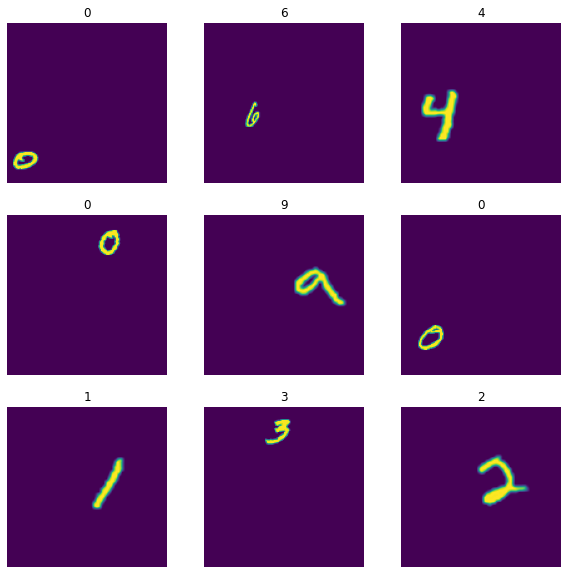

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `Model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [40]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 1)
(32,)


The `image_batch` is a tensor of the shape `(32, 128, 128, 1)`. This is a batch of 32 images of shape `128x128x1` (the last dimension refers to color channels GrayScale). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [42]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [43]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


2022-05-02 11:47:08.030862: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

# Create the model

In [44]:
num_classes = len(class_names)

RNN_model = Sequential([
  layers.Input(shape = (128, 128)),
  layers.Rescaling(1./255),
  layers.SimpleRNN(128, activation = 'tanh'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [45]:
RNN_model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

## Model summary

View all the layers of the network using the model's `Model.summary` method:

In [46]:
RNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 128, 128)          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 34,186
Trainable params: 34,186
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [47]:
epochs = 10
RNN_history = RNN_model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/10
2435/2435 [==============================] - 84s 34ms/step - loss: 2.3039 - accuracy: 0.1093 - val_loss: 2.3057 - val_accuracy: 0.1110
Epoch 2/10
2435/2435 [==============================] - 80s 33ms/step - loss: 2.2983 - accuracy: 0.1148 - val_loss: 2.2999 - val_accuracy: 0.1188
Epoch 3/10
2435/2435 [==============================] - 80s 33ms/step - loss: 2.2989 - accuracy: 0.1125 - val_loss: 2.2955 - val_accuracy: 0.1176
Epoch 4/10
2435/2435 [==============================] - 80s 33ms/step - loss: 2.3039 - accuracy: 0.1195 - val_loss: 2.3068 - val_accuracy: 0.1072
Epoch 5/10
2435/2435 [==============================] - 81s 33ms/step - loss: 2.2941 - accuracy: 0.1214 - val_loss: 2.3021 - val_accuracy: 0.1037
Epoch 6/10
2435/2435 [==============================] - 80s 33ms/step - loss: 2.2962 - accuracy: 0.1167 - val_loss: 2.3015 - val_accuracy: 0.1152
Epoch 7/10
2435/2435 [==============================] - 80s 33ms/step - loss: 2.2990 - accuracy: 0.1169 - val_loss: 2.2910 -

## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

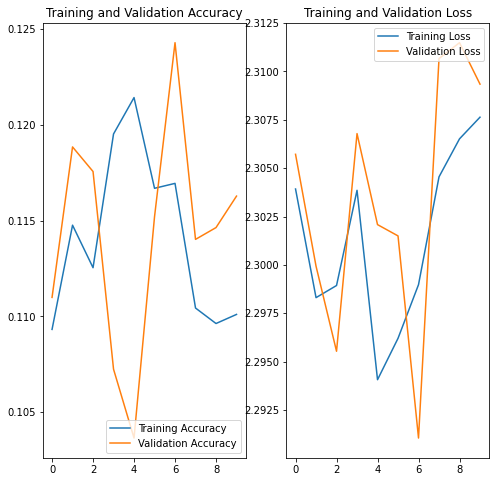

In [48]:
RNNacc = RNN_history.history['accuracy']
RNNval_acc = RNN_history.history['val_accuracy']

RNNloss = RNN_history.history['loss']
RNNval_loss = RNN_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, RNNacc, label = 'Training Accuracy')
plt.plot(epochs_range, RNNval_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, RNNloss, label = 'Training Loss')
plt.plot(epochs_range, RNNval_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
LSTM_model = Sequential([
  layers.Input(shape = (128, 128)),
  layers.Rescaling(1./255),
  layers.LSTM(128, activation = 'tanh'),
  layers.Dense(num_classes)
])

In [50]:
LSTM_model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [51]:
LSTM_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 128, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 132,874
Trainable params: 132,874
Non-trainable params: 0
_________________________________________________________________


In [52]:
epochs = 10
LSTM_history = LSTM_model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/10
2435/2435 [==============================] - 14s 6ms/step - loss: 2.1864 - accuracy: 0.1543 - val_loss: 2.2994 - val_accuracy: 0.1031
Epoch 2/10
2435/2435 [==============================] - 13s 5ms/step - loss: 2.0687 - accuracy: 0.1817 - val_loss: 1.7024 - val_accuracy: 0.2854
Epoch 3/10
2435/2435 [==============================] - 13s 5ms/step - loss: 1.0732 - accuracy: 0.5840 - val_loss: 0.6048 - val_accuracy: 0.7769
Epoch 4/10
2435/2435 [==============================] - 13s 5ms/step - loss: 0.4959 - accuracy: 0.8147 - val_loss: 0.4398 - val_accuracy: 0.8341
Epoch 5/10
2435/2435 [==============================] - 13s 5ms/step - loss: 0.3717 - accuracy: 0.8627 - val_loss: 0.3226 - val_accuracy: 0.8932
Epoch 6/10
2435/2435 [==============================] - 13s 5ms/step - loss: 0.2613 - accuracy: 0.9144 - val_loss: 0.2223 - val_accuracy: 0.9312
Epoch 7/10
2435/2435 [==============================] - 13s 5ms/step - loss: 0.1885 - accuracy: 0.9417 - val_loss: 0.1864 - val_ac

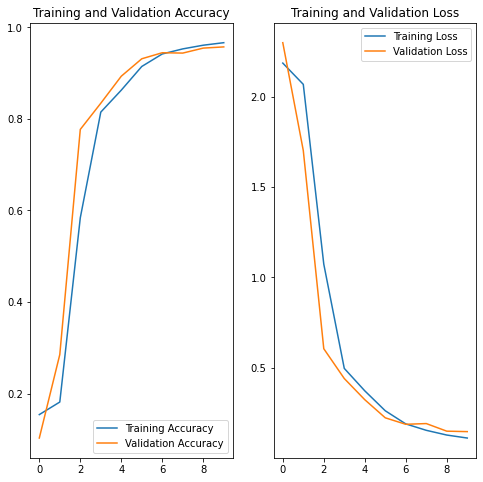

In [53]:
LSTMacc = LSTM_history.history['accuracy']
LSTMval_acc = LSTM_history.history['val_accuracy']

LSTMloss = LSTM_history.history['loss']
LSTMval_loss = LSTM_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, LSTMacc, label = 'Training Accuracy')
plt.plot(epochs_range, LSTMval_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, LSTMloss, label = 'Training Loss')
plt.plot(epochs_range, LSTMval_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
GRU_model = Sequential([
  layers.Input(shape = (128, 128)),
  layers.Rescaling(1./255),
  layers.GRU(128, activation = 'tanh'),
  layers.Dense(num_classes)
])

In [55]:
GRU_model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [56]:
GRU_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 128, 128)          0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 100,362
Trainable params: 100,362
Non-trainable params: 0
_________________________________________________________________


In [57]:
epochs = 10
GRU_history = GRU_model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/10
2435/2435 [==============================] - 17s 7ms/step - loss: 2.0859 - accuracy: 0.1866 - val_loss: 1.3125 - val_accuracy: 0.4456
Epoch 2/10
2435/2435 [==============================] - 16s 6ms/step - loss: 0.7385 - accuracy: 0.7141 - val_loss: 0.4807 - val_accuracy: 0.8191
Epoch 3/10
2435/2435 [==============================] - 16s 6ms/step - loss: 0.4264 - accuracy: 0.8392 - val_loss: 0.3841 - val_accuracy: 0.8573
Epoch 4/10
2435/2435 [==============================] - 15s 6ms/step - loss: 0.3029 - accuracy: 0.8933 - val_loss: 0.2584 - val_accuracy: 0.9167
Epoch 5/10
2435/2435 [==============================] - 16s 6ms/step - loss: 0.1909 - accuracy: 0.9393 - val_loss: 0.1779 - val_accuracy: 0.9441
Epoch 6/10
2435/2435 [==============================] - 15s 6ms/step - loss: 0.1463 - accuracy: 0.9533 - val_loss: 0.1531 - val_accuracy: 0.9531
Epoch 7/10
2435/2435 [==============================] - 16s 6ms/step - loss: 0.1206 - accuracy: 0.9622 - val_loss: 0.1499 - val_ac

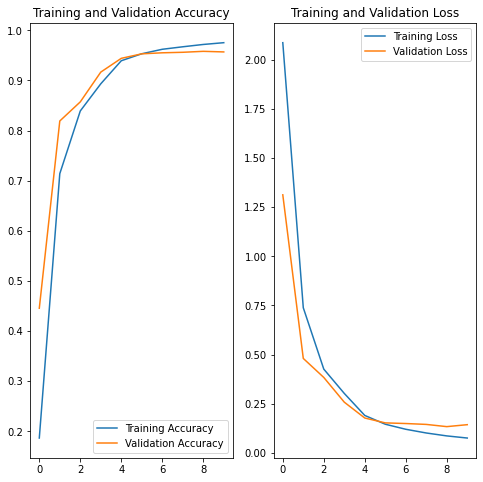

In [58]:
GRUacc = GRU_history.history['accuracy']
GRUval_acc = GRU_history.history['val_accuracy']

GRUloss = GRU_history.history['loss']
GRUval_loss = GRU_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, GRUacc, label = 'Training Accuracy')
plt.plot(epochs_range, GRUval_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, GRUloss, label = 'Training Loss')
plt.plot(epochs_range, GRUval_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

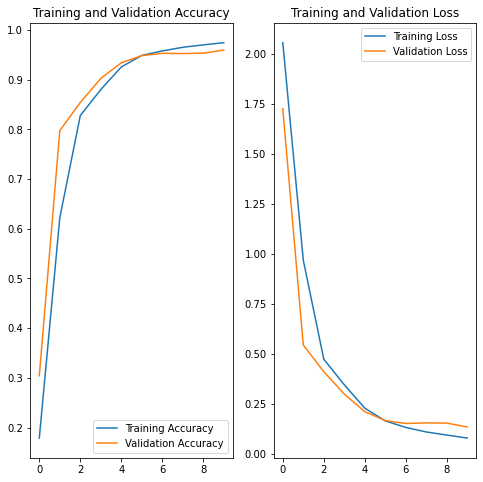

In [59]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()